# Import libraries

In [1]:
import os
import sys 

import cv2
import imutils
from imutils.contours import sort_contours
from IPython.display import SVG
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
import livelossplot
plot_losses = livelossplot.PlotLossesKeras()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from pdf2image import convert_from_path 
from PIL import Image 
import pytesseract 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

from modules.helpers import auto_canny, data_summary

sns.set()

dataset_path = '../data/CURATED/dataset/alphabet-dataset/handwritten-data.csv'
image_path = '../data/images/formation.jpeg'

NUM_ROWS = 28
NUM_COLS = 28
BATCH_SIZE = 128
EPOCHS = 10

Using TensorFlow backend.


In [4]:
dataset = pd.read_csv(dataset_path).astype('float32')
dataset.rename(columns={'0':'label'}, inplace=True)

# Split data the X - Our data , and y - the predict label
X = dataset.drop('label', axis = 1)
y = dataset['label']

In [12]:
print("shape:", X.shape)
print(f"culomns count: {len(X.iloc[1])} = {NUM_ROWS}x{NUM_COLS}")

X.head()

shape: (372450, 784)
culomns count: 784 = 28x28
= 28X28


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


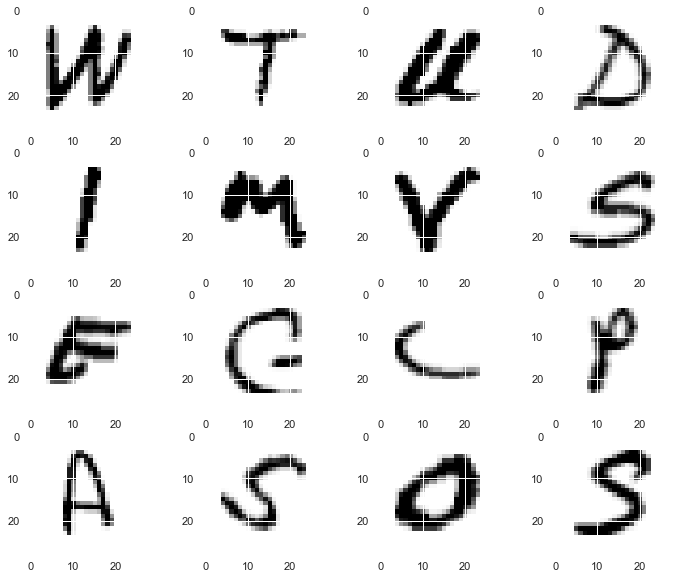

In [8]:
X_shuffle = shuffle(X)

plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_shuffle.iloc[i].values.reshape(NUM_ROWS, NUM_COLS),interpolation='nearest', cmap='Greys')
plt.show()

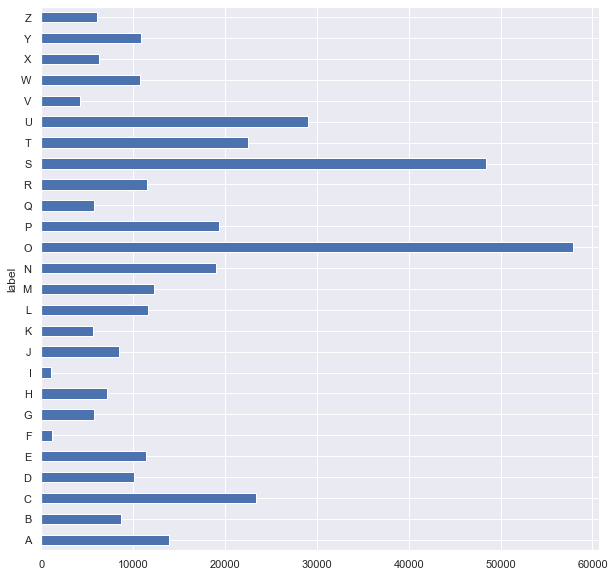

We have very low observations for I and F 
I count: 1120
F count: 1163


In [9]:
# Change label to alphabets
alphabets_mapper = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'} 
dataset_alphabets = dataset.copy()
dataset['label'] = dataset['label'].map(alphabets_mapper)

label_size = dataset.groupby('label').size()
label_size.plot.barh(figsize=(10,10))
plt.show()

print("We have very low observations for I and F ")
print("I count:", label_size['I'])
print("F count:", label_size['F'])

In [17]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y)

data_summary(X_train, y_train, X_test, y_test)

# scale data
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

Train images shape: (279337, 784)
Train labels shape: (279337,)
Test images shape: (93113, 784)
Test labels shape: (93113,)
Train labels: 167573    14.0
82385      8.0
197279    14.0
104645    11.0
348046    22.0
          ... 
77372      7.0
49213      3.0
80884      7.0
213046    15.0
323066    20.0
Name: label, Length: 279337, dtype: float32
Test labels: 127364    13.0
217896    16.0
223592    17.0
17146      1.0
247868    18.0
          ... 
154338    14.0
301930    19.0
67112      4.0
297996    19.0
279249    18.0
Name: label, Length: 93113, dtype: float32


Data after scaler


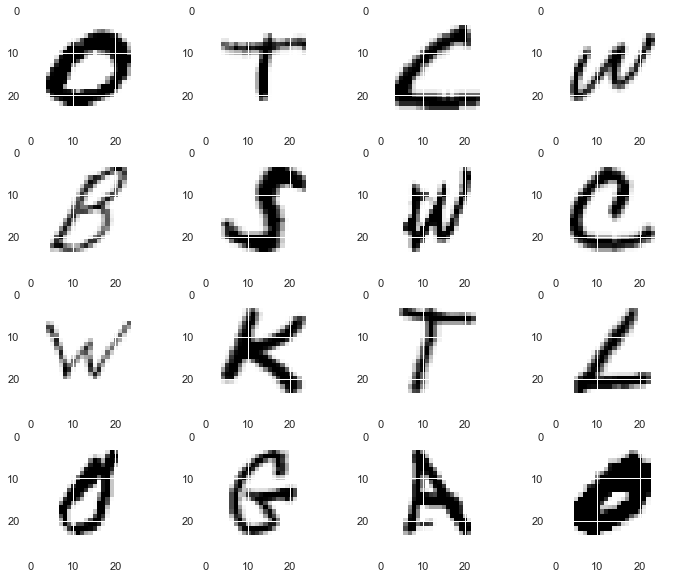

In [18]:
print("Data after scaler")
X_shuffle = shuffle(X_train)

plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_shuffle[i].reshape(NUM_ROWS, NUM_COLS),interpolation='nearest', cmap='Greys')
plt.show()

In [19]:
# Reshape data
X_train = X_train.reshape(X_train.shape[0], NUM_ROWS, NUM_COLS, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], NUM_ROWS, NUM_COLS, 1).astype('float32')

# Categorically encode labels
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Check state of dataset
data_summary(X_train, y_train, X_test, y_test)

Train images shape: (279337, 28, 28, 1)
Train labels shape: (279337, 26)
Test images shape: (93113, 28, 28, 1)
Test labels shape: (93113, 26)
Train labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Test labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Model creation

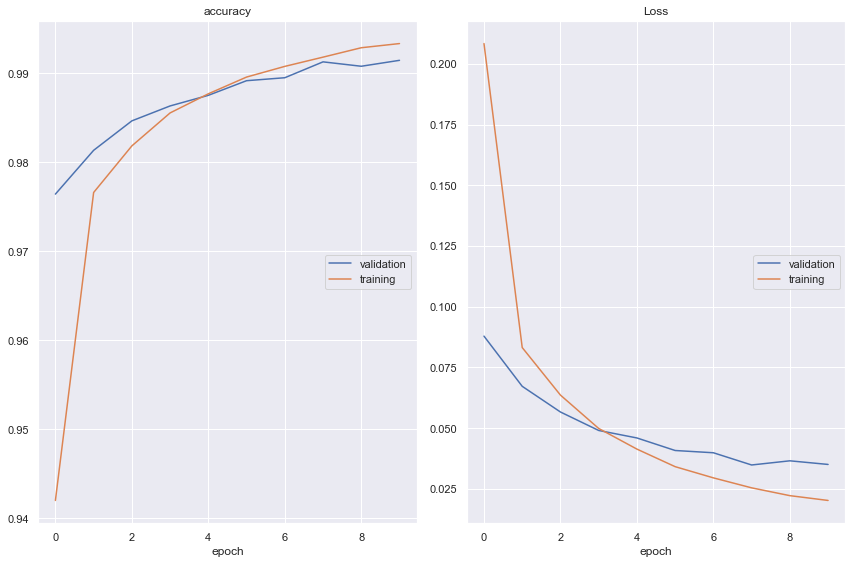

accuracy
	validation       	 (min:    0.976, max:    0.991, cur:    0.991)
	training         	 (min:    0.942, max:    0.993, cur:    0.993)
Loss
	validation       	 (min:    0.035, max:    0.088, cur:    0.035)
	training         	 (min:    0.020, max:    0.208, cur:    0.020)
Test loss: 0.13437005204651506
CNN Score: 0.9914297461509705


In [20]:
# Build neural network
cls = Sequential()
cls.add(Conv2D(32, (5, 5), input_shape=(NUM_ROWS, NUM_COLS, 1), activation='relu'))
cls.add(MaxPooling2D(pool_size=(2, 2)))
cls.add(Dropout(0.3))
cls.add(Flatten())
cls.add(Dense(128, activation='relu'))
cls.add(Dense(len(y.unique()), activation='softmax'))

# Compile model
cls.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = cls.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE,          callbacks=[plot_losses], verbose=2)

scores = cls.evaluate(X_test,y_test, verbose=0)
print('Test loss:', score[0])
print("CNN Score:",scores[1])
cls.save('model.h5')

<AxesSubplot:>

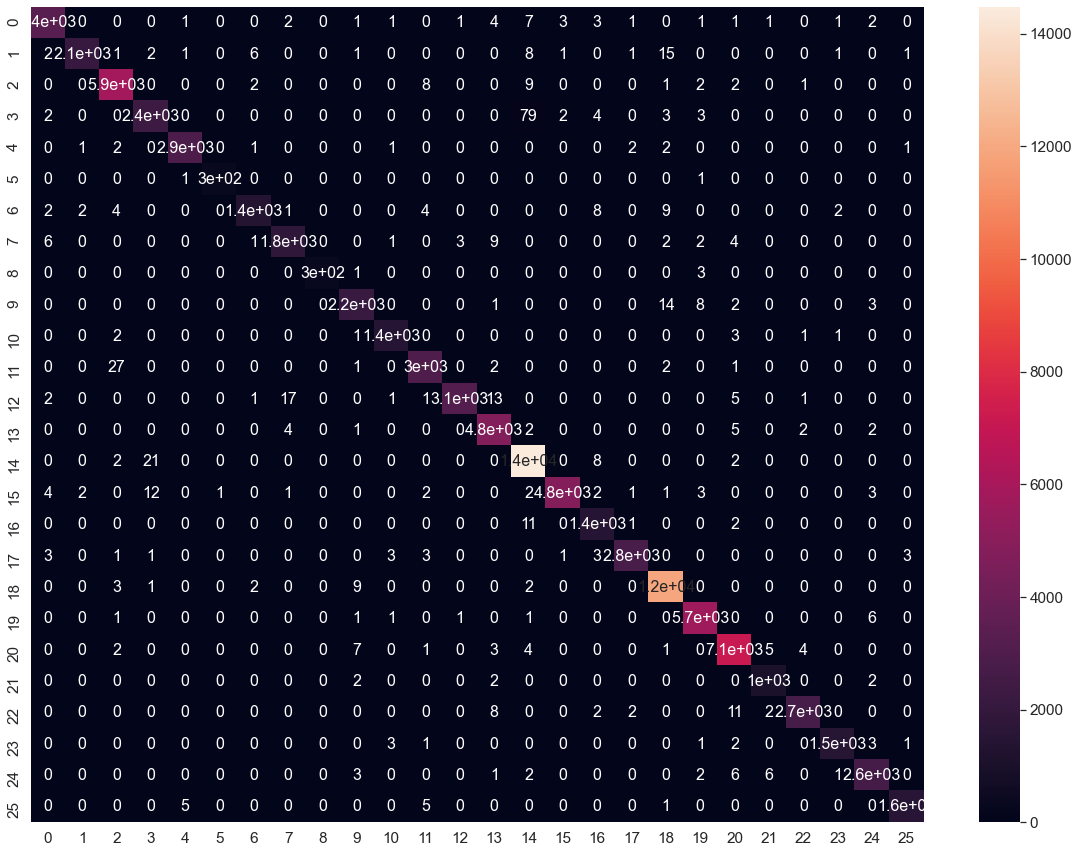

In [11]:
cm=confusion_matrix(y_test.argmax(axis=1),cls.predict(X_test).argmax(axis=1))
df_cm = pd.DataFrame(cm, range(26),
                  range(26))
plt.figure(figsize = (20,15))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [18]:
from skimage import transform
from PIL import Image

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (NUM_ROWS, NUM_COLS, 1))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

model = load_model('model.h5')
alphabets_mapper = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'} 

img = load('../data/CURATED/dataset/alphabet-dataset/W/W-46.png')
classes = model.predict_classes(img)

print(alphabets_mapper[classes[0]])

W


# Text Recognition

### Using OpenCV

Load the image file

In [32]:
image = cv2.imread(image_path)

Convert it to grayscale

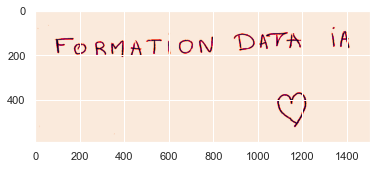

In [33]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

## The Canny edge detection algorithm can be broken down into 5 steps:
## Step 1: Noise Reduction
### Since edge detection is susceptible to noise in the image, first step is to remove the noise in the image with a 5x5 Gaussian filter. We have already seen this in previous chapters.


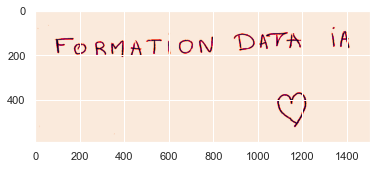

In [34]:
blurred = cv2.medianBlur(gray, 5)
plt.imshow(gray)

In [18]:
edged = auto_canny(blurred)
plt.imshow(edged)

NameError: name 'auto_canny' is not defined

* RETR_EXTERNAL gives "outer" contours, so if you have (say) one contour enclosing another (like concentric circles), only the outermost is given.
* CHAIN_APPROX_SIMPLE  removes all redundant points and compresses the contour, thereby saving memory.

In [36]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

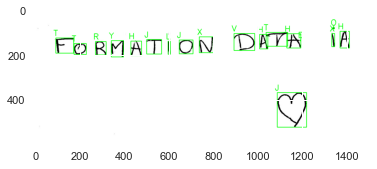

In [22]:
# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

# loop over the contours
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    roi = gray[y:y + h, x:x + w]
    thresh = cv2.threshold(roi, 0, 255,
                               cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
                               
    # re-grab the image dimensions (now that its been resized)
    # and then determine how much we need to pad the width and
    # height such that our image will be 32x32
    (tH, tW) = thresh.shape
    dX = int(max(0, NUM_ROWS - tW) / 2.0)
    dY = int(max(0, NUM_COLS - tH) / 2.0)

    padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                                    left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
    padded = cv2.resize(padded, (NUM_ROWS, NUM_COLS))
    # prepare the padded image for classification via our
    # handwriting OCR model
    padded = padded.astype("float32") / 255.0
    padded = np.expand_dims(padded, axis=-1)
    # update our list of characters that will be OCR'd
    chars.append((padded, (x, y, w, h)))

# show the image
plt.imshow(image)

In [23]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model

preds = model.predict(chars)
# define the list of label names
# labelNames = "0123456789"
labelNames = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    # draw the prediction on the image
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x - 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

[INFO] T - 78.66%
[INFO] T - 93.18%
[INFO] R - 96.92%
[INFO] Y - 100.00%
[INFO] H - 98.93%
[INFO] J - 62.40%
[INFO] L - 99.83%
[INFO] J - 96.21%
[INFO] X - 99.99%
[INFO] V - 97.08%
[INFO] H - 68.91%
[INFO] T - 67.26%
[INFO] J - 99.77%
[INFO] H - 98.93%
[INFO] E - 88.67%
[INFO] X - 84.31%
[INFO] O - 96.81%
[INFO] H - 99.08%


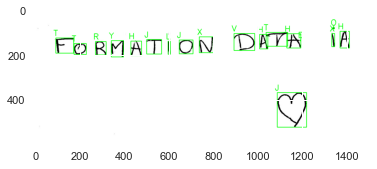

In [24]:
# show the image
plt.imshow(image)

### Using Tesseract

In [11]:
def ocr_core(filename):
    """
    This function will handle the core OCR processing of images.
    """
    text = pytesseract.image_to_string(Image.open(filename))  # We'll use Pillow's Image class to open the image and pytesseract to detect the string in the image
    return text

print(ocr_core(image_path))

FORMATION DATA 1A

Y



# Bonus 1: MNIST

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Train labels: [5 0 4 ... 5 6 8]
Test labels: [7 2 1 ... 4 5 6]


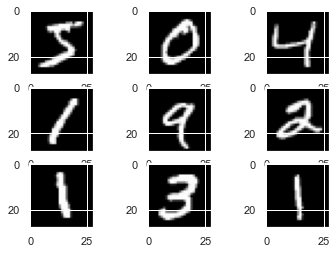

In [2]:
# example of loading the mnist dataset
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# summarize loaded dataset
data_summary(X_train, y_train, X_test, y_test)

# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [4]:
# Reshape data
X_train = X_train.reshape((X_train.shape[0], NUM_ROWS, NUM_COLS, 1)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], NUM_ROWS, NUM_COLS, 1)).astype('float32') / 255

# Categorically encode labels
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Check state of dataset
data_summary(X_train, y_train, X_test, y_test)

Train images shape: (60000, 28, 28, 1)
Train labels shape: (60000, 10)
Test images shape: (10000, 28, 28, 1)
Test labels shape: (10000, 10)
Train labels: [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Test labels: [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


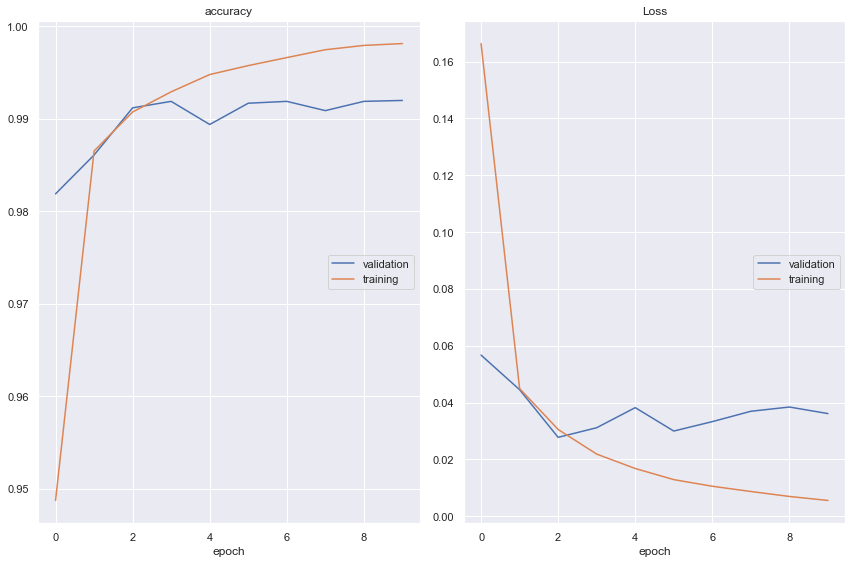

accuracy
	validation       	 (min:    0.982, max:    0.992, cur:    0.992)
	training         	 (min:    0.949, max:    0.998, cur:    0.998)
Loss
	validation       	 (min:    0.028, max:    0.057, cur:    0.036)
	training         	 (min:    0.006, max:    0.166, cur:    0.006)


NameError: name 'cls' is not defined

In [5]:
# Build neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[plot_losses],
          verbose=1,
          validation_data=(X_test, y_test))

cls.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE,          callbacks=[plot_losses], verbose=2)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

"""Summarize and visualize the model"""
# Summary of neural network
model.summary()

# Output network visualization
SVG(model_to_dot(model).create(prog='dot', format='svg'))
model.save('model_mnist.h5')

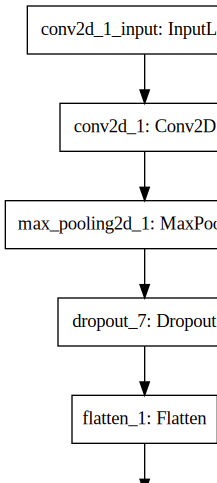

In [6]:
# Output network visualization
model = load_model('model_mnist.h5')

SVG(model_to_dot(model).create(prog='dot', format='svg'))
# model.save('model_mnist.h5')

In [7]:
from skimage import transform
from PIL import Image

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32') / 255
    np_image = transform.resize(np_image, (NUM_ROWS, NUM_COLS, 1))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image


model = load_model('model_mnist.h5')

img = load('../data/images/7.png')
classes = model.predict_classes(img)

print(classes[0])

14


# Bonus 2: Reading contents of PDF using OCR (Optical Character Recognition)

In [5]:
# Path of the pdf 
PDF_file = "../data/AvisMedical.pdf"

### Part #1 : Converting PDF to images 

In [ ]:
# Store all the pages of the PDF in a variable 
pages = convert_from_path(PDF_file, 500) 
  
# Counter to store images of each page of PDF to image 
image_counter = 1
  
# Iterate through all the pages stored above 
for page in pages: 
    # Declaring filename for each page of PDF as JPG 
    # For each page, filename will be: 
    # PDF page 1 -> page_1.jpg 
    # PDF page 2 -> page_2.jpg 
    # PDF page 3 -> page_3.jpg 
    # .... 
    # PDF page n -> page_n.jpg 
    filename = "../data/images/page_"+str(image_counter)+".jpg"
      
    # Save the image of the page in system 
    page.save(filename, 'JPEG') 
  
    # Increment the counter to update filename 
    image_counter = image_counter + 1
  

### Part #2 - Recognizing text from the images using OCR 

In [ ]:
# Variable to get count of total number of pages 
filelimit = image_counter-1
  
# Creating a text file to write the output 
outfile = "../data/images/out_text.txt"
  
# Open the file in append mode so that  
# All contents of all images are added to the same file 
f = open(outfile, "a") 

pytesseract.pytesseract.tesseract_cmd = r'C:\Users\utilisateur\AppData\Local\Tesseract-OCR\tesseract.exe'  
# Iterate from 1 to total number of pages 
for i in range(1, filelimit + 1): 
  
    # Set filename to recognize text from 
    # Again, these files will be: 
    # page_1.jpg 
    # page_2.jpg 
    # .... 
    # page_n.jpg 
    filename = "../data/images/page_"+str(i)+".jpg"
          
    # Recognize the text as string in image using pytesseract
    text = str(((pytesseract.image_to_string(Image.open(filename))))) 
  
    # The recognized text is stored in variable text 
    # Any string processing may be applied on text 
    # Here, basic formatting has been done: 
    # In many PDFs, at line ending, if a word can't 
    # be written fully, a 'hyphen' is added. 
    # The rest of the word is written in the next line 
    # Eg: This is a sample text this word here GeeksF- 
    # orGeeks is half on first line, remaining on next. 
    # To remove this, we replace every '-\n' to ''. 
    text = text.replace('-\n', '')     
  
    # Finally, write the processed text to the file. 
    f.write(text) 
  
# Close the file after writing all the text. 
f.close() 

In [8]:
text_file = open('../data/out_text.txt')
file_content = text_file.read()
print(file_content)
text_file.close()

Trenhivwile Wh SWNMYVING “ AVI VILLI.
cera) (Art. R. 212-2, R. 221-10 42 R 221-14-1, R. 221-19 et R. 226-1 aR. 2264 du Code de la route)
1°14880*02 (Arrété du 31 juillet 2012 modifié relatif a l'organisation du contréle médical de l'aptitude a la conduite)
a)

Nom de BouSFIRA

naissance
(C'est le nom qui figure sur votre acte de naissance)
—
Prénom(s) DIAM EL
(Dans l'ordre de !'état civil}
Nom d'usage
{sil y a lieu)

{ex : nom d'époux(se))

Dale de Jour 3 © Mois A A Année, A 2 3G Sexe : Femme ZHomme _ perlabio. O ‘| 6 4 4 oe OK A +

naissance

Commune de ‘ qa Département ou

naissance a Y OW’ Cc Collectivité d'outre-mer O 6 2
Pays

(Si vous étes né(¢6} a i’étranger)

Adresse 5 fR VE

N° de la voie Extension : bis, ter, etc, Type de voie : avenue, boulevard, etc.
GEER NS 4h-t58) 716 8
Nom de la voie

Complément
d'adresse
(Etage, escalier, appartement - Immeuble, batiment, résidence - Lieu-dit, Boite postale, Commune déléguée)

Code postal 6 > 2 C) Commune A VG I € QE
Courriel Ws Bous C1